In [1]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Reshape, Activation
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Cuda version: {}".format(tf_build_info.cuda_version_number))
print("Cudnn version: {}".format(tf_build_info.cudnn_version_number))
print("Num Physical GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num Logical GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

NETWORK_W          = 608
NETWORK_H          = 608

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Mish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'


def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))
    
   
    

get_custom_objects().update({'mish': Mish(mish)})

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)), name='zerop_' + str(conv['layer_idx']))(x)  # peculiar padding as darknet prefer left and top
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)
        
        if conv['bnorm']: x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)    
        
        if conv['activ'] == 1: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        if conv['activ'] == 2: x = Activation('mish', name='mish_' + str(conv['layer_idx']))(x) 
            
    return add([skip_connection, x],  name='add_' + str(conv['layer_idx']+1)) if skip else x

def make_yolov4_model():
  
    input_image = Input(shape=(NETWORK_H, NETWORK_W, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 0}])
    layer_0 = x
    # Layer  1
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 1}])
    layer_1 = x
    
    # Layer  2 
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 2}])
    layer_2 = x
    
    # route  1 (layers = -2)
    x = layer_1
    # Layer  3 => 5
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 4},
                        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 6}],
                   skip = True)

    # Layer  8 => 8
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 8}])
    layer_8 = x
    
    # route  8+2 (layers = -1, -7)
    x = concatenate([layer_8, layer_2], name='concat_9')
    
    # Layer 10 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 10},
                        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 11}])
    layer_11 = x
    
    # Layer  12
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 12}])
    layer_12 = x
    
    # route  11 (layers = -2)
    x = layer_11
    # Layer 14 => 16
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 14},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 15},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 16}],
                   skip = True)
    
    # Layer 18 => 19
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 18},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 19}],
                   skip = True)
    
    # Layer  21
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 21}]) 
    layer_21 = x
    
    # route  21+12 (layers = -1,-10)
    x = concatenate([layer_21, layer_12], name='concat_22')
    
    # Layer 23 => 24
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 23},
                        {'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 24}])
    layer_24 = x
    
    # Layer  25
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 25}])
    layer_25 = x
    
    # route  24 (layers = -2)
    x = layer_24
    
    # Layer 27 => 29
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 27},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 28},
                        {'filter':  128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 29}],
                   skip = True)
    
    # Layer 31 => 50
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 31+(i*3)},
                            {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 32+(i*3)}],
                       skip = True)
  
    # Layer  52
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 52}])
    layer_52 = x
        
    # route  52+25 (layers = -1,-28)
    x = concatenate([layer_52, layer_25],  name='concat_53')
    
    # Layer 54
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 54}])
    layer_54 = x
    
    # Layer  55
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 55}])
    layer_55 = x
    
    # Layer  56
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 56}])
    layer_56 = x
    
    # route  55 (layers = -2)
    x = layer_55
    
    # Layer 58 => 60
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 58},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 59},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 60}],
                   skip = True)     

    # Layer 62 => 81
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 62+(i*3)},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 63+(i*3)}],
                       skip = True)

    # Layer  83
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 83}])
    layer_83 = x

    # route  83+56 (layers = -1,-28)
    x = concatenate([layer_83, layer_56], name='concat_84')
    
    # Layer 85
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 85}])
    layer_85 = x
    
    # Layer  86
    x = _conv_block(x, [{'filter':  1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 86}])
    layer_86 = x
    
    # Layer  87
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 87}])
    layer_87 = x
        
    # route  86 (layers = -2)
    x = layer_86
    
    # Layer 89 => 92
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 89},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 90},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 91}],
                   skip = True) 
    
    
    # Layer 93 => 100
    for i in range(3):
        x = _conv_block(x, [{'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 93+(i*3)},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 94+(i*3)}],
                       skip = True)  
    
    
    # Layer  102 => 102
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 102}])  
    layer_102 = x
    
    # route  102+87 (layers = -1,-16)
    x = concatenate([layer_102, layer_87], name='concat_103')
    
    # Layer 104 => 107
    x = _conv_block(x, [{'filter':  1024, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 104},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 105},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 106},                        
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 107}])
    layer_107 = x
    
    # Layer 108
    x =MaxPool2D(pool_size=(5, 5), strides=1, padding='same', name = 'layer_108')(x)  
    layer_108 = x
    
    # route  107 (layers = -2)
    x = layer_107
    
    # Layer 110
    x =MaxPool2D(pool_size=(9, 9), strides=1, padding='same', name = 'layer_110')(x)    
    layer_110 = x
    
    # route  107 (layers = -4)
    x = layer_107
        
    # Layer 112
    x =MaxPool2D(pool_size=(13, 13), strides=1, padding='same', name = 'layer_112')(x) 
    layer_112 = x
    
    # route  112+110+108+107 (layers=-1,-3,-5,-6)
    x = concatenate([layer_112, layer_110, layer_108, layer_107], name='concat_113')
    layer_113 = x
    
    # Layer 114 => 116
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 114},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 115},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 116}])
    layer_116 = x
                        
    # Layer 117                    
    x = _conv_block(x, [{'filter':   256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 117}])
    layer_117 = x
    # Layer 118
    x = UpSampling2D(size=(2, 2), name = 'upsamp_118')(x)
    layer_118 = x
                        
    # route  85 (layers = 85)
    x = layer_85
    
    # Layer 120
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 120}])
    layer_120 = x
                        
    # route  120+118 (layers = -1, -3)
    x = concatenate([layer_120, layer_118],  name='concat_121')
    layer_121 = x                    
    # Layer 122 => 126
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 122},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 123},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 124},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 125},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 126}])
    layer_126 = x 
                        
    # Layer 127                    
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 127}])
    layer_127 = x
    # Layer 128
    x = UpSampling2D(size=(2, 2), name = 'upsamp_128')(x)
    layer_128 = x
                        
    # route  54 (layers = 54)
    x = layer_54
    
    # Layer 130
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 130}])
    layer_130 = x
                        
    # route  130+128 (layers = -1, -3)                 
    x = concatenate([layer_130, layer_128],  name='concat_131')
    layer_131 = x                    
    # Layer 132 => 136
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 132},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 133},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 134},  
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 135},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 136}])
    layer_136 = x                   
    
    # Layer 137 => 138
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 137}]) 
    layer_137 = x 
    x = _conv_block(x, [{'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 138}])   
  
    # Layer 139
    yolo_139 = x
                        
    # route  136 (layers = -4)
    x = layer_136
    
    # Layer 141
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 141}])
    layer_141 = x
                        
    # route  141+126 (layers = -1, -16)                   
    x = concatenate([layer_141, layer_126],  name='concat_142')
    
    # Layer 143 => 147
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 143},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 144},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 145},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 146},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 147}])  
    layer_147 = x
                        
    # Layer 148 => 149                    
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 148},
                        {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 149}])
                        
    # Layer 150
    yolo_150 = x                  
    
    # route  147 (layers = -4)
    x = layer_147
        
    # Layer 152
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 152}])
    layer_152 = x  
                        
    # route  152+166 (layers = -1, -37)                   
    x = concatenate([layer_152, layer_116],  name='concat_153') 
                        
                        
    # Layer 154 => 160
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 154},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 155},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 156},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 157},  
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 158},   
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 159},
                        {'filter':   255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    0, 'layer_idx': 160}])  
                     
                        
    # Layer 161
    yolo_161 = x
                           
    model = Model(input_image, [yolo_139, yolo_150, yolo_161], name = 'Yolo_v4')    
    
    return model

Using TensorFlow backend.


TensorFlow version: 2.1.0
Eager execution: True
Keras version: 2.2.4-tf
Cuda version: 10.1
Cudnn version: 7
Num Physical GPUs Available:  0
Num Logical GPUs Available:  0


In [2]:
# define the model
model = make_yolov4_model()

In [3]:
model.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
convn_0 (Conv2D)                (None, 608, 608, 32) 896         input_0[0][0]                    
__________________________________________________________________________________________________
BN_0 (BatchNormalization)       (None, 608, 608, 32) 128         convn_0[0][0]                    
__________________________________________________________________________________________________
mish_0 (Activation)             (None, 608, 608, 32) 0           BN_0[0][0]                       
____________________________________________________________________________________________

In [4]:
from keras.models import Model
import struct

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                print("reading 64 bytes")
                w_f.read(8)
            else:
                print("reading 32 bytes")
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        count = 0
        ncount = 0
        for i in range(161):
            try:

                conv_layer = model.get_layer('convn_' + str(i))
                filter = conv_layer.kernel.shape[-1]
                nweights = np.prod(conv_layer.kernel.shape) # kernel*kernel*c*filter
                
                print("loading weights of convolution #" + str(i)+ "- nb parameters: "+str(nweights+filter))             
                
                if i  in [138, 149, 160]:
                    print("Special processing for layer "+ str(i))
                    bias  = self.read_bytes(filter) # bias
                    weights = self.read_bytes(nweights) # weights
                
                else:                    
                    bias  = self.read_bytes(filter) # bias
                    scale = self.read_bytes(filter) # scale
                    mean  = self.read_bytes(filter) # mean
                    var   = self.read_bytes(filter) # variance
                    weights = self.read_bytes(nweights) # weights
                    
                    bias = bias - scale  * mean / (np.sqrt(var + 0.00001)) #normalize bias

                    weights = np.reshape(weights,(filter,int(nweights/filter)))  #normalize weights
                    A = scale / (np.sqrt(var + 0.00001))
                    A= np.expand_dims(A,axis=0)
                    weights = weights* A.T
                    weights = np.reshape(weights,(nweights))
                

                weights = weights.reshape(list(reversed(conv_layer.get_weights()[0].shape)))                 
                weights = weights.transpose([2,3,1,0])
                
                if len(conv_layer.get_weights()) > 1:
                    a=conv_layer.set_weights([weights, bias])
                else:    
                    a=conv_layer.set_weights([weights])
                
                count = count+1
                ncount = ncount+nweights+filter
             
            except ValueError:
                print("no convolution #" + str(i)) 
        
        print(count, "Conv normalized layers loaded ", ncount, " parameters")
    
    def reset(self):
        self.offset = 0

In [5]:
# Get and compute the weights
weight_reader = WeightReader('models/yolo/yolov4.weights')
weight_reader.load_weights(model)

reading 64 bytes
loading weights of convolution #0- nb parameters: 896
loading weights of convolution #1- nb parameters: 18496
loading weights of convolution #2- nb parameters: 4160
no convolution #3
loading weights of convolution #4- nb parameters: 4160
loading weights of convolution #5- nb parameters: 2080
loading weights of convolution #6- nb parameters: 18496
no convolution #7
loading weights of convolution #8- nb parameters: 4160
no convolution #9
loading weights of convolution #10- nb parameters: 8256
loading weights of convolution #11- nb parameters: 73856
loading weights of convolution #12- nb parameters: 8256
no convolution #13
loading weights of convolution #14- nb parameters: 8256
loading weights of convolution #15- nb parameters: 4160
loading weights of convolution #16- nb parameters: 36928
no convolution #17
loading weights of convolution #18- nb parameters: 4160
loading weights of convolution #19- nb parameters: 36928
no convolution #20
loading weights of convolution #21-

In [6]:
# save the model to file
! rm models\yolo\yolov4.h5

model.save('models/yolo/yolov4.h5')
! dir models\yolo\*.h5

 Le volume dans le lecteur C s'appelle Windows
 Le num‚ro de s‚rie du volume est CCDC-AB26

 R‚pertoire de C:\Users\edh\yolo4\Yolov-4\models\yolo

12/07/2020  10:16        35ÿ584ÿ360 yolov3-tiny.h5
16/07/2020  08:26       258ÿ879ÿ904 yolov4.h5
               2 fichier(s)      294ÿ464ÿ264 octets
               0 R‚p(s)  292ÿ115ÿ443ÿ712 octets libres


In [7]:
# Load the model
from keras.models import load_model, Model
yolo_model = load_model("models/yolo/yolov4.h5")

C:\Users\edh\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
# Freeze the backbone

# Fine-tune from this layer onwards
fine_tune_at = "convn_136"

# Freeze all the layers before the `fine_tune_at` layer
train = False
for l in yolo_model.layers:
  if l.name == fine_tune_at:
        train = True        
  l.trainable =  train
    

# Display the trainable indicator
for l in yolo_model.layers:
    print("layer ",l.name, " trainable: ", l.trainable)

layer  input_0  trainable:  False
layer  convn_0  trainable:  False
layer  BN_0  trainable:  False
layer  mish_0  trainable:  False
layer  zerop_1  trainable:  False
layer  convn_1  trainable:  False
layer  BN_1  trainable:  False
layer  mish_1  trainable:  False
layer  convn_4  trainable:  False
layer  BN_4  trainable:  False
layer  mish_4  trainable:  False
layer  convn_5  trainable:  False
layer  BN_5  trainable:  False
layer  mish_5  trainable:  False
layer  convn_6  trainable:  False
layer  BN_6  trainable:  False
layer  mish_6  trainable:  False
layer  add_7  trainable:  False
layer  convn_8  trainable:  False
layer  convn_2  trainable:  False
layer  BN_8  trainable:  False
layer  BN_2  trainable:  False
layer  mish_8  trainable:  False
layer  mish_2  trainable:  False
layer  concat_9  trainable:  False
layer  convn_10  trainable:  False
layer  BN_10  trainable:  False
layer  mish_10  trainable:  False
layer  zerop_11  trainable:  False
layer  convn_11  trainable:  False
layer  B

In [9]:
yolo_model.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
convn_0 (Conv2D)                (None, 608, 608, 32) 896         input_0[0][0]                    
__________________________________________________________________________________________________
BN_0 (BatchNormalization)       (None, 608, 608, 32) 128         convn_0[0][0]                    
__________________________________________________________________________________________________
mish_0 (Activation)             (None, 608, 608, 32) 0           BN_0[0][0]                       
____________________________________________________________________________________________

In [10]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [11]:
# Load the labels
labels = read_labels("models/yolo/coco_classes.txt")
print(labels)
print("Nb labels:", len(labels))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
Nb labels: 80


In [12]:
NETWORK_W        = 608
NETWORK_H        = 608
NB_BOX           = 3
NB_CLASS         = len(labels)
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
grids = [(76,76), (38,38), (19,19)]
anchors = [ [12, 16, 19, 36, 40, 28],[36, 75, 76, 55, 72, 146],[142, 110, 192, 243, 459, 401]]
scales_x_y = [1.2, 1.1, 1.05]
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 2
TRUE_BOX_BUFFER  = 50

In [13]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
     
        

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h
    
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union


class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score

In [14]:
import xml.etree.ElementTree as ET
import pickle
import os
from os import listdir, getcwd
from os.path import join

def convert(image_wh, box, grid_w, grid_h, Boxanchor, yolo_id):
    dw = image_wh[0]/ grid_w
    dh = image_wh[1]/ grid_h
    center_x = (box[0] + box[1])/2.0
    center_x = center_x / dw
    center_y = (box[2] + box[3])/2.0
    center_y = center_y / dh
    
    grid_x = int(np.floor(center_x))
    grid_y = int(np.floor(center_y))
    
    if grid_x < grid_w and grid_y < grid_h:
        w = (box[1] - box[0]) / dw
        h = (box[3] - box[2]) / dh
        
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
    
        shifted_box = BoundBox(0,0,w,h)
    
        for i in range(len(anchors[yolo_id])//2):
            iou    = bbox_iou(shifted_box, Boxanchor[i])                   
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
    
        return (center_x,center_y,w,h,grid_x,grid_y,best_anchor)
    
    else: # not compatible with the grid size
        return (0,0,0,0,0,0,-1)
    

def convert_annotation(year, image_set, image_id, grid_w, grid_h, Boxanchor, yolo_id, VOC_path):
    in_file = open(VOC_path+'VOC%s\\Annotations\\%s.xml'%(year, image_id))
    out_file = open('VOCYoloV4\\VOC%s_%s\\labels_%s\\%s.txt'%(year, image_set, yolo_id, image_id), 'w')
    tree=ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    image_w = int(size.find('width').text)
    image_h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in labels or int(difficult)==1:
            continue
        cls_id = labels.index(cls)
        
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((image_w,image_h), b, grid_w, grid_h, Boxanchor, yolo_id)
        
        if bb[-1] != -1:
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')


def build_label_files (year, image_set, VOC_path):
    yolo_id = 0
    
    for grid_w, grid_h in grids:
        print("grid :",grid_w, grid_h)

        Boxanchor= [BoundBox(0, 0, anchors[yolo_id][2*i], anchors[yolo_id][2*i+1]) for i in range(int(len(anchors[yolo_id])//2))]
       
        if not os.path.exists('VOCYoloV4\\VOC%s_%s\\labels_%s\\' %(year, image_set, yolo_id)):
            os.makedirs('VOCYoloV4\\VOC%s_%s\\labels_%s\\' %(year, image_set, yolo_id))
        
        image_ids = open(VOC_path+'VOC%s\\ImageSets\\Main\\%s.txt'%(year, image_set)).read().strip().split()

        for image_id in image_ids:
            convert_annotation(year, image_set, image_id, grid_w, grid_h, Boxanchor, yolo_id, VOC_path)
            
        yolo_id+=1
    return    

In [15]:
# Build the labels files for VOC train dataset
VOC_path = '..\\train\\VOCdevkit\\'
build_label_files ('2012', 'train', VOC_path)

grid : 76 76
grid : 38 38
grid : 19 19


In [16]:
# Build the labels files for VOC validation dataset
build_label_files ('2012', 'val', VOC_path)

grid : 76 76
grid : 38 38
grid : 19 19


In [17]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [18]:
def build_train (year, image_set, nb_train, VOC_path):
 
    train_x  = np.zeros ((nb_train, NETWORK_H, NETWORK_W, 3), dtype=np.float32)
    train_y0 = np.zeros ((nb_train, grids[0][1], grids[0][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    train_y1 = np.zeros ((nb_train, grids[1][1], grids[1][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    train_y2 = np.zeros ((nb_train, grids[2][1], grids[2][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    bc = 0 
        
    image_ids = open(VOC_path+'VOC%s\\ImageSets\\Main\\%s.txt'%(year, image_set)).read().strip().split()

    
    for image_id in image_ids:        
        # Pre-process the image train_x
        img_filename = VOC_path+'VOC%s\\JPEGImages\\%s.jpg'%(year, image_id)
        print(img_filename)
        image, image_w, image_h = load_image_pixels(img_filename, (NETWORK_W, NETWORK_H))
        train_x[bc,:,:,:] = image
        
        # build true predict train_y0 and box b0
        labels_file = open('VOCYoloV4\\VOC%s_%s\\labels_0\\%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
            
        # build true predict train_y1 and box b1
        labels_file = open('VOCYoloV4\\VOC%s_%s\\labels_1\\%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        true_box_index = 0
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.

        # build true predict train_y2 and box b2
        labels_file = open('VOCYoloV4\\VOC%s_%s\\labels_2\\%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        true_box_index = 0
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
             
        bc+=1
        if bc == nb_train:
            break
        
    train_y0 = np.reshape (train_y0, (nb_train, grids[0][1], grids[0][0], NB_BOX*(4+1+NB_CLASS)))
    train_y1 = np.reshape (train_y1, (nb_train, grids[1][1], grids[1][0], NB_BOX*(4+1+NB_CLASS)))
    train_y2 = np.reshape (train_y2, (nb_train, grids[2][1], grids[2][0], NB_BOX*(4+1+NB_CLASS)))
        
    return(train_x,  [train_y0,train_y1,train_y2])    

In [19]:
# Compute the data for training
VOC_path = '..\\train\\VOCdevkit\\'
nb_data_for_training= 4
train_x, train_y = build_train('2012', 'train', (nb_data_for_training//BATCH_SIZE)*BATCH_SIZE, VOC_path)

..\train\VOCdevkit\VOC2012\JPEGImages\2008_000008.jpg
..\train\VOCdevkit\VOC2012\JPEGImages\2008_000015.jpg
..\train\VOCdevkit\VOC2012\JPEGImages\2008_000019.jpg
..\train\VOCdevkit\VOC2012\JPEGImages\2008_000023.jpg


In [20]:
# Compute the data for validation
nb_data_for_validation= 4
val_x, val_y = build_train('2012', 'val', (nb_data_for_validation//BATCH_SIZE)*BATCH_SIZE, VOC_path)

..\train\VOCdevkit\VOC2012\JPEGImages\2008_000002.jpg
..\train\VOCdevkit\VOC2012\JPEGImages\2008_000003.jpg
..\train\VOCdevkit\VOC2012\JPEGImages\2008_000007.jpg
..\train\VOCdevkit\VOC2012\JPEGImages\2008_000009.jpg


In [21]:
def custom_loss(y_true, y_pred):

    grid_h, grid_w = y_pred.shape[1:3] 
    
    if grid_h == grids[0][0]:
        anchor = anchors[0]
    elif grid_h == grids[1][0]: 
        anchor = anchors[1]
    else:    
        anchor = anchors[2]     
    print("anchor",anchor)    
    
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.cast((tf.reshape(tf.tile(tf.range(grid_w), [grid_h]), (1, grid_h, grid_w, 1, 1))),dtype=tf.float32)
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, NB_BOX, 1])
    
    
    ######  prediction
    y_pred = tf.reshape(y_pred, (BATCH_SIZE, grid_h, grid_w, NB_BOX, NB_CLASS+5))
    print ("prediction", y_pred.shape)
    
    ### adjust x and y  
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) # x, y)
    pred_box_xy = pred_box_xy + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(anchor, [1,1,1,NB_BOX,2]) / np.full((1,1,1,NB_BOX, 2), [NETWORK_W, NETWORK_H])

    
    ### adjust objectness
    pred_box_obj = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = tf.sigmoid(y_pred[..., 5:])
    
    
    ######  true
    y_true = tf.reshape(y_true, (BATCH_SIZE, grid_h, grid_w, NB_BOX, NB_CLASS+5))
    print ("true", y_true.shape)

    ### adjust x and y  
    true_box_xy = y_true[..., :2] # x, y
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4]
    
    ### adjust objectness
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas + 1e-10
    iou_scores  = tf.truediv(intersect_areas, union_areas)
   
    true_box_obj = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)

    
    
    ######  coefficients   
   
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is an object in the cell i, else 0.
    coord_mask = tf.zeros(mask_shape)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### objectness mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    for i in range(BATCH_SIZE):
        bd = y_true[i,:,:,:,:4]
        nozero = tf.not_equal(bd, tf.zeros((grid_h, grid_w, NB_BOX, 4)))
        bdd = tf.boolean_mask(bd, nozero)
        s=tf.squeeze(tf.size(bdd)//4)
        c= tf.zeros((50-s,4))
        bdd=tf.reshape(bdd, (s,4))
        bdd = tf.concat([bdd,c],axis=0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        if (i==0):
            true_boxes =bdd
        else:
            true_boxes = tf.concat([true_boxes,bdd], axis=0)  
    
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    best_ious = tf.reduce_max(iou_scores, axis=4)
    
    obj_mask = tf.zeros(mask_shape)
    obj_mask = tf.cast((best_ious < 0.6),dtype=tf.float32) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    obj_mask = obj_mask + y_true[..., 4] * OBJECT_SCALE

    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is a particular class is predicted, else 0.
    class_mask = tf.zeros(mask_shape)
    class_weights = np.ones(NB_CLASS, dtype='float32')
    class_mask = y_true[..., 4] * tf.gather(class_weights, true_box_class) * CLASS_SCALE
    
    nb_coord_box = tf.reduce_sum(tf.cast((coord_mask > 0.0),dtype=tf.float32))
    nb_obj_box  = tf.reduce_sum(tf.cast((obj_mask  > 0.0),dtype=tf.float32))
    nb_class_box = tf.reduce_sum(tf.cast((class_mask > 0.0),dtype=tf.float32))
      
    ### loss
    loss_xy    = tf.reduce_sum(coord_mask * tf.square(true_box_xy - pred_box_xy)) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(coord_mask * tf.square(tf.sqrt(tf.abs(true_box_wh)) - tf.sqrt(tf.abs(pred_box_wh)))) / (nb_coord_box + 1e-6) / 2.
    loss_obj   = tf.reduce_sum(obj_mask * tf.square(true_box_obj-pred_box_obj)) / (nb_obj_box + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(class_mask * loss_class) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_obj + loss_class
    print()
    return loss


In [22]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

#optimizer = tf.keras.optimizers.SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD.RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

In [23]:
# Compile the model using the custom loss function defined above
yolo_model.compile(loss=custom_loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

anchor [12, 16, 19, 36, 40, 28]
prediction (2, 76, 76, 3, 85)
true (2, 76, 76, 3, 85)

anchor [36, 75, 76, 55, 72, 146]
prediction (2, 38, 38, 3, 85)
true (2, 38, 38, 3, 85)

anchor [142, 110, 192, 243, 459, 401]
prediction (2, 19, 19, 3, 85)
true (2, 19, 19, 3, 85)



In [24]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting train")

    def on_train_end(self, logs=None):
        print("Stop train")
        
    def on_epoch_begin(self, epoch, logs=None):
        print("--Start epoch {}".format(epoch))

    def on_epoch_end(self, epoch, logs=None):
        print("--End epoch {}, the average training loss is {:7.2f}, testing loss is {:7.2f}".format(epoch, logs["loss"], logs["val_loss"]))        
        
    def on_train_batch_begin(self, batch, logs=None):
        print("---Start training batch {}, size {}".format(batch,logs["size"]))
        
    def on_train_batch_end(self, batch, logs=None):
        print("---End training batch {}, total loss is {:7.2f}, loss (76*76) is {:7.2f}, loss (38*38) is {:7.2f}, loss (19*19) is {:7.2f}"
              .format(batch, logs["loss"],logs["BN_138_loss"],logs["BN_149_loss"],logs["BN_160_loss"]))      

    def on_test_begin(self, logs=None):
        print("-Start testing")
        
    def on_test_end(self, logs=None):
        print("-Stop testing")
    
    def on_test_batch_begin(self, batch, logs=None):
        print("---Start testing batch {}, size {}".format(batch,logs["size"]))
        
    def on_test_batch_end(self, batch, logs=None):
        print("---End testing batch {}, total loss is {:7.2f}, loss (76*76) is {:7.2f}, loss (38*38) is {:7.2f}, loss (19*19) is {:7.2f}"
              .format(batch, logs["loss"],logs["BN_138_loss"],logs["BN_149_loss"],logs["BN_160_loss"]))  

In [25]:
# Fit the model including validation data
import datetime
start = datetime.datetime.now()

EScallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = yolo_model.fit(x=train_x, y=train_y, validation_data = (val_x,val_y), epochs= 3,batch_size =BATCH_SIZE, verbose=2, callbacks=[CustomCallback(),EScallback ])

elapsed = datetime.datetime.now()-start
print("elapsed seconds: ",elapsed.seconds)

Train on 4 samples, validate on 4 samples
Starting train
Epoch 1/3
--Start epoch 0
---Start training batch 0, size 2
---End training batch 0, total loss is   55.09, loss (76*76) is   29.99, loss (38*38) is   16.24, loss (19*19) is    8.86
---Start training batch 1, size 2
---End training batch 1, total loss is   65.17, loss (76*76) is   32.77, loss (38*38) is   17.57, loss (19*19) is    9.79
-Start testing
---Start testing batch 0, size 2
---End testing batch 0, total loss is   89.68, loss (76*76) is   48.47, loss (38*38) is   25.94, loss (19*19) is   15.27
---Start testing batch 1, size 2
---End testing batch 1, total loss is   43.19, loss (76*76) is   35.39, loss (38*38) is   19.33, loss (19*19) is   11.72
-Stop testing
 - 37s - loss: 60.1315 - BN_138_loss: 32.7729 - BN_149_loss: 17.5655 - BN_160_loss: 9.7930 - BN_138_root_mean_squared_error: 1.0054 - BN_149_root_mean_squared_error: 1.0053 - BN_160_root_mean_squared_error: 1.0053 - val_loss: 66.4329 - val_BN_138_loss: 35.3901 - val_B

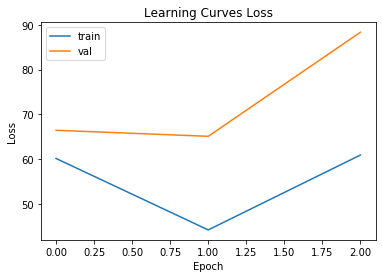

In [26]:
# plot learning curves Loss
from matplotlib import pyplot
pyplot.title('Learning Curves Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

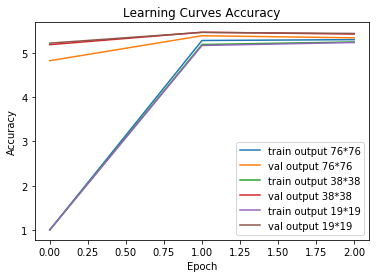

In [27]:
# plot learning curves Accuracy
from matplotlib import pyplot
pyplot.title('Learning Curves Accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.plot(history.history['BN_138_root_mean_squared_error'], label='train output 76*76')
pyplot.plot(history.history['val_BN_138_root_mean_squared_error'], label='val output 76*76')
pyplot.plot(history.history['BN_149_root_mean_squared_error'], label='train output 38*38')
pyplot.plot(history.history['val_BN_149_root_mean_squared_error'], label='val output 38*38')
pyplot.plot(history.history['BN_160_root_mean_squared_error'], label='train output 19*19')
pyplot.plot(history.history['val_BN_160_root_mean_squared_error'], label='val output 19*19')
pyplot.legend()
pyplot.show()